# The ROMS vertical grid
I'm using some packages that I've developed over the years as a basis for this. They are [xroms](https://github.com/xoceanmodel/xroms) and [octant.depths](https://github.com/hetland/octant/blob/master/octant/depths.py).

Here. I've pulled out the relevant code to simplify the discussion, which hopefully is sufficient for demonstration purposes.


In [32]:
import numpy as np
import matplotlib.pyplot as plt

## Vstretching

These have all been simplified -- no limits are checked, and no docs.
see https://github.com/hetland/octant/blob/master/octant/depths.py#L74 for 
full info, docs, etc.

In [8]:


def get_Vstretching_1(theta_s, theta_b):
    def C(s):
        a = theta_s
        b = theta_b
        return (1 - b) * (np.sinh(s * a) / np.sinh(a)) + \
                b * (-0.5 + 0.5 * np.tanh(a * (s + 0.5)) / np.tanh(0.5 * a))
    return C

def get_Vstretching_2(theta_s, theta_b):
    def C(s):
        return (1.0 - np.cosh(theta_s * s)) / (np.cosh(theta_s) - 1.0)
    return C


def get_Vstretching_4(theta_s, theta_b):
    def C(s):
        C = (1.0 - np.cosh(theta_s * s)) / (np.cosh(theta_s) - 1.0)
        return (np.exp(theta_b * C) - 1.0) / (1.0 - np.exp(-theta_b))
    return C

## VTransform

These have also all been simplified -- no limits are checked, and no docs.
see https://github.com/hetland/octant/blob/master/octant/depths.py#L283 for 
full info, docs, etc.

In [9]:
def get_Vtransform_1(C, h, hc):
    def Zo(s):
        if np.ndim(h) == 1:
            s = s[:, np.newaxis]
        if np.ndim(h) == 2:
            s = s[:, np.newaxis, np.newaxis]

        assert hc <= np.min(h), 'hc cannot be larger than the minimum depth'

        return hc * (s - C(s)) + C(s) * h
    return Zo


def get_Vtransform_2(C, h, hc):
    def Zo(s):
        if np.ndim(h) == 1:
            s = s[:, np.newaxis]
        if np.ndim(h) == 2:
            s = s[:, np.newaxis, np.newaxis]

        return (hc * s + C(s) * h) / (hc + h)
    return Zo


## scoord

These are all pretty straightforward. They are just the uniformly spaced s-coordinate (from -1 at the sea floor to 0 at the free surface).

In [10]:
def get_sw(N):
    'return N evenly s-coordinate w-points.'
    return np.linspace(-1.0, 0.0, N)


def get_srho(N):
    'return N evenly spaced s-coordinate rho-points'
    sr = np.linspace(-1.0, 0.0, N+1)
    return 0.5 * (sr[1:] + sr[:-1])


## Get the depths

Again, see https://github.com/hetland/octant/blob/master/octant/depths.py#L360 for details

This walks you through the steps in creating a physical vertical coordinate

In [57]:

N = 30        # the number of vertical levels.
theta_s = 5.0
theta_b = 0.5
h = np.linspace(10, 200, 10)
hc = 40
zeta = 0.0

sw = get_sw(N+1)    # need to add an extra layer since s_w has one more layer than s_rho

C = get_Vstretching_4(theta_s, theta_b)

Zo = get_Vtransform_2(C, h, hc)

z_w = zeta + (zeta + h) * Zo(sw)

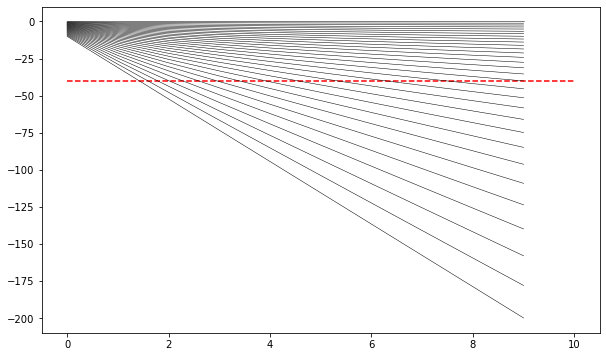

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(z_w.T, 'k-', lw=0.5);
ax.hlines(-hc, 0, len(h), ls='--', color='r')

In [48]:
plt.hlines?

Signature:
plt.hlines(
    y,
    xmin,
    xmax,
    colors=None,
    linestyles='solid',
    label='',
    *,
    data=None,
    **kwargs,
)
Docstring:
Plot horizontal lines at each *y* from *xmin* to *xmax*.

Parameters
----------
y : float or array-like
    y-indexes where to plot the lines.

xmin, xmax : float or array-like
    Respective beginning and end of each line. If scalars are
    provided, all lines will have same length.

colors : list of colors, default: :rc:`lines.color`

linestyles : {'solid', 'dashed', 'dashdot', 'dotted'}, optional

label : str, default: ''

Returns
-------
`~matplotlib.collections.LineCollection`

Other Parameters
----------------
**kwargs :  `~matplotlib.collections.LineCollection` properties.

See Also
--------
vlines : vertical lines
axhline : horizontal line across the Axes

Notes
-----


.. note::
    In addition to the above described arguments, this function can take
    a *data* keyword argument. If such a *data* argument is given,
    the 